In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast

import koreanize_matplotlib

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

## 1. accounts_attendance(출석)

In [143]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [144]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [ ]:
# 사용 데이터 기간 2023년 5,6,7월

# 출석 횟수를 알아보자
attendance_df = attendance.copy()

# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [ ]:
# import datetime

# # 분석 기간 정의
# start_date = datetime.date(2023, 5, 1)
# end_date = datetime.date(2023, 7, 31)

# # 문자열 리스트를 datetime 리스트로 변환하고 필터링 후 길이 계산
# attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(
#     lambda dates: sum(
#         start_date <= datetime.datetime.strptime(d, "%Y-%m-%d").date() <= end_date
#         for d in dates
#     )
# )

# # 확인
# attendance_df[['user_id', 'attendance_count']]

,user_id,attendance_count
0,1446852,10
1,1359398,26
2,1501542,9
3,1507767,30
4,1287453,31
...,...,...
349632,897005,0
349633,1407059,0
349634,1583727,0
349635,1392372,0


In [166]:
# 월별 출석 확인 횟수 확인

# explode로 풀어서 하나의 row로
attendance_exploded = attendance_df.explode('attendance_date_list')
attendance_exploded

# attendance_date_list datetime으로 형식 변경 => 결측 NaT
attendance_exploded['attendance_date_list'] = pd.to_datetime(attendance_exploded['attendance_date_list'])
attendance_exploded

,id,attendance_date_list,user_id,attendance_count
0,1,2023-05-27,1446852,10
0,1,2023-05-28,1446852,10
0,1,2023-05-29,1446852,10
0,1,2023-05-30,1446852,10
0,1,2023-06-03,1446852,10
...,...,...,...,...
349632,360501,NaT,897005,0
349633,360502,2024-05-09,1407059,0
349634,360503,2024-05-09,1583727,0
349635,360504,2024-05-09,1392372,0


In [152]:
attendance_exploded['month'] = attendance_exploded['attendance_date_list'].dt.month
attendance_exploded['year'] = attendance_exploded['attendance_date_list'].dt.year

attendance_filtered = attendance_exploded[
    (attendance_exploded['year'] == 2023) &
    (attendance_exploded['month'].isin([5,6,7]))
].copy()

attendance_filtered['month'] = attendance_filtered['month'].astype(int)
attendance_filtered['year'] = attendance_filtered['year'].astype(int)
attendance_filtered

display(attendance_filtered)

attendance_count = attendance_filtered.groupby(['user_id', 'month']).size().reset_index(name='attendance_count')
attendance_count

,id,attendance_date_list,user_id,attendance_count,month,year
0,1,2023-05-27,1446852,13,5,2023
0,1,2023-05-28,1446852,13,5,2023
0,1,2023-05-29,1446852,13,5,2023
0,1,2023-05-30,1446852,13,5,2023
0,1,2023-06-03,1446852,13,6,2023
...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023
339378,350176,2023-07-31,1537582,1,7,2023
339379,350177,2023-07-31,1345721,1,7,2023
339380,350178,2023-07-31,1307547,1,7,2023


,user_id,month,attendance_count
0,832151,5,1
1,832340,6,2
2,832986,5,1
3,833041,5,5
4,833041,6,9
...,...,...,...
552808,1579618,7,1
552809,1579623,7,1
552810,1579628,7,1
552811,1579632,7,1


In [171]:
# 1. 날짜 정렬
attendance_exploded_sorted = attendance_exploded.sort_values(['user_id', 'attendance_date_list'])

# 2. user_id 기준으로 날짜 간격 차이 계산
attendance_exploded_sorted['day_diff'] = (
    attendance_exploded_sorted.groupby('user_id')['attendance_date_list']
    .diff().dt.days
)

# 3. 평균 방문 텀 계산
average_gap_df = (
    attendance_exploded_sorted
    .groupby('user_id')['day_diff']
    .mean()
    .reset_index()
    .rename(columns={'day_diff': 'avg_visit_gap'})
)

# 4. 방문이 1회인 유저는 NaN → 0 처리
average_gap_df['avg_visit_gap'] = average_gap_df['avg_visit_gap'].fillna(0)

# 결과 출력
average_gap_df

,user_id,avg_visit_gap
0,832151,0.000000
1,832340,1.000000
2,832986,0.000000
3,833041,4.961538
4,833112,3.000000
...,...,...
349632,1583710,0.000000
349633,1583711,0.000000
349634,1583715,0.000000
349635,1583727,0.000000


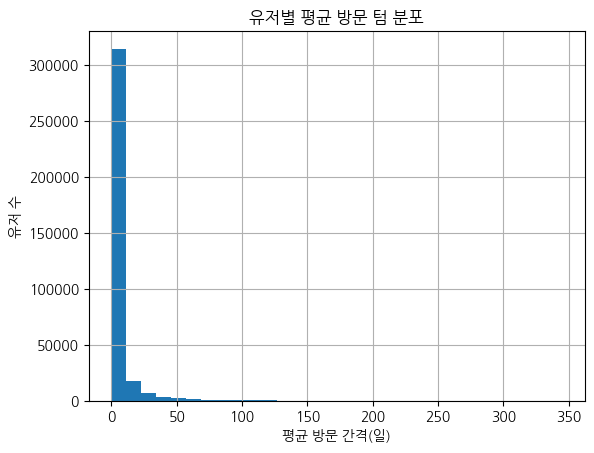

In [ ]:
# 유저별 평균 방문텀 분포
average_gap_df['avg_visit_gap'].hist(bins=30)
plt.title('유저별 평균 방문 텀 분포')
plt.xlabel('평균 방문 간격(일)')
plt.ylabel('유저 수')
plt.grid(True)
plt.show()

In [148]:
# 유저별 접속 기간 확인
user_period_df = (
    attendance_exploded.dropna(subset=['attendance_date_list'])  # 접속일이 NaT인 경우 제거
    .groupby('user_id')['attendance_date_list']
    .agg(['min', 'max'])  # 최소일, 최대일
    .reset_index()
)

# 접속 기간 계산 (최소 1일 보장)
user_period_df['active_days'] = (user_period_df['max'] - user_period_df['min']).dt.days + 1
user_period_df

,user_id,min,max,active_days
0,832151,2023-05-29,2023-05-29,1
1,832340,2023-06-05,2023-06-06,2
2,832986,2023-05-28,2023-05-28,1
3,833041,2023-05-27,2024-02-09,259
4,833112,2023-09-18,2023-09-24,7
...,...,...,...,...
328687,1583708,2024-05-06,2024-05-06,1
328688,1583710,2024-05-05,2024-05-05,1
328689,1583715,2024-05-05,2024-05-05,1
328690,1583727,2024-05-09,2024-05-09,1


In [150]:
attendance_count_df = (
    attendance_exploded
    .dropna(subset=['attendance_date_list'])
    .groupby('user_id')['attendance_date_list']
    .nunique()
    .reset_index(name='attendance_days')
)

In [151]:
# 접속 기간과 실제 접속일 수 비교
user_period_df = user_period_df.merge(attendance_count_df, on='user_id')
user_period_df['active_density'] = user_period_df['attendance_days'] / user_period_df['active_days']
user_period_df

,user_id,min,max,active_days,attendance_days,active_density
0,832151,2023-05-29,2023-05-29,1,1,1.000000
1,832340,2023-06-05,2023-06-06,2,2,1.000000
2,832986,2023-05-28,2023-05-28,1,1,1.000000
3,833041,2023-05-27,2024-02-09,259,53,0.204633
4,833112,2023-09-18,2023-09-24,7,3,0.428571
...,...,...,...,...,...,...
328687,1583708,2024-05-06,2024-05-06,1,1,1.000000
328688,1583710,2024-05-05,2024-05-05,1,1,1.000000
328689,1583715,2024-05-05,2024-05-05,1,1,1.000000
328690,1583727,2024-05-09,2024-05-09,1,1,1.000000


Text(0, 0.5, '유저 수')

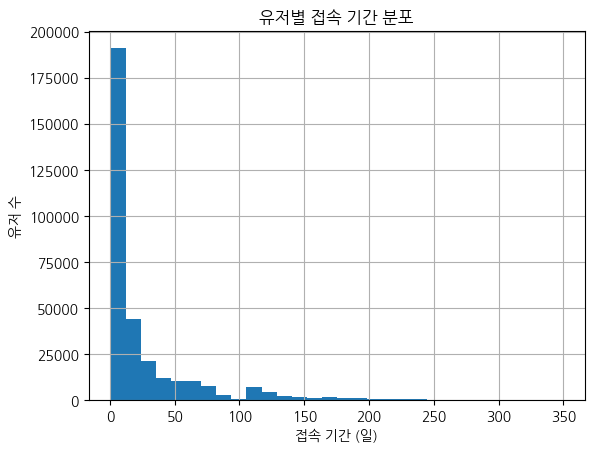

In [168]:
# 사용자 전체 체류 기간 시각화
user_period_df['active_days'].hist(bins=30)
plt.title('유저별 접속 기간 분포')
plt.xlabel('접속 기간 (일)')
plt.ylabel('유저 수')


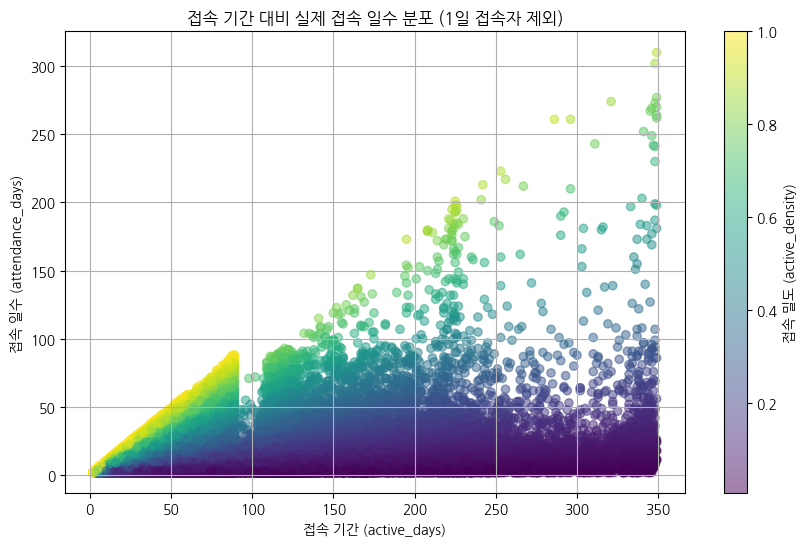

In [162]:
filtered_df = user_period_df[
    ~((user_period_df['active_days'] == 1) & (user_period_df['attendance_days'] == 1))
]

plt.figure(figsize=(10,6))
plt.scatter(
    filtered_df['active_days'],
    filtered_df['attendance_days'],
    c=filtered_df['active_density'],
    cmap='viridis',
    alpha=0.5
)
plt.xlabel('접속 기간 (active_days)')
plt.ylabel('접속 일수 (attendance_days)')
plt.title('접속 기간 대비 실제 접속 일수 분포 (1일 접속자 제외)')
plt.colorbar(label='접속 밀도 (active_density)')
plt.grid(True)
plt.show()


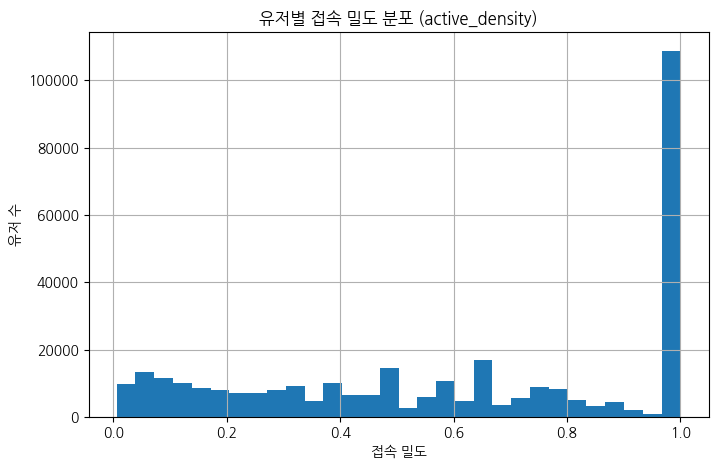

In [157]:
user_period_df['active_density'].hist(bins=30, figsize=(8,5))
plt.title('유저별 접속 밀도 분포 (active_density)')
plt.xlabel('접속 밀도')
plt.ylabel('유저 수')
plt.grid(True)
plt.show()

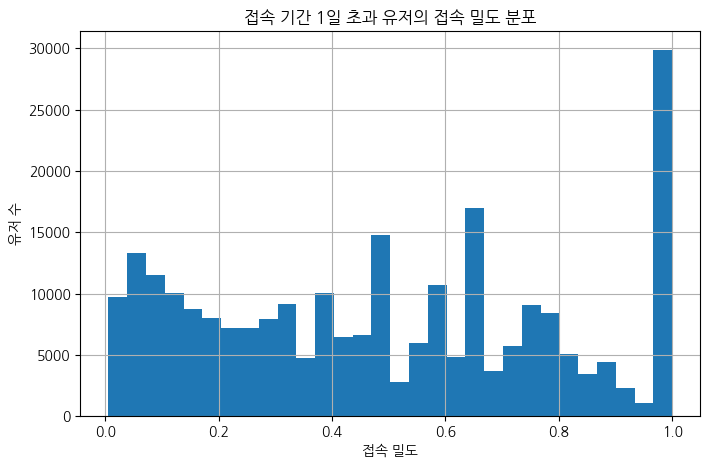

In [ ]:
# 출석 기간 1일이고 출석 횟수도 1일 제외 후 밀도 시각화
filtered_df = user_period_df[user_period_df['active_days'] > 1]
filtered_df['active_density'].hist(bins=30, figsize=(8,5))
plt.title('접속 기간 1일 초과 유저의 접속 밀도 분포')
plt.xlabel('접속 밀도')
plt.ylabel('유저 수')
plt.grid(True)
plt.show()

In [153]:
# 5,6,7 월별 출석휫수 시각화
monthly_attendance = attendance_count.groupby('month')['attendance_count'].sum().reset_index()
monthly_attendance.columns = ['월', '출석횟수']
monthly_attendance = monthly_attendance.sort_values('월')  # 월별 정렬
monthly_attendance

,월,출석횟수
0,5,611238
1,6,1232776
2,7,200306


In [154]:
# 피봇 테이블 형성 -> 더 보기 좋게
attendance_pivot = attendance_count.pivot(index='user_id', columns='month', values='attendance_count').fillna(0).astype(int)
attendance_pivot.columns = [f'{month}월' for month in attendance_pivot.columns]
attendance_pivot

,5월,6월,7월
user_id,,,
832151,1,0,0
832340,0,2,0
832986,1,0,0
833041,5,9,18
833154,1,0,0
...,...,...,...
1579618,0,0,1
1579623,0,0,1
1579628,0,0,1


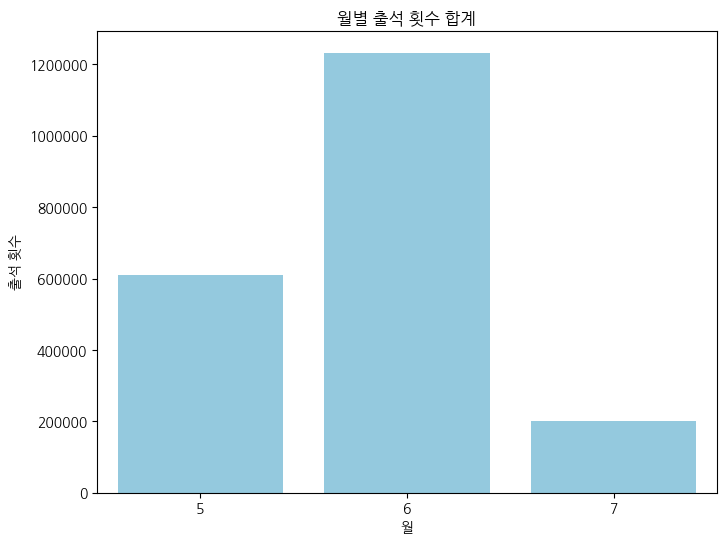

In [11]:
# 월별 누적 출석 횟수 시각화화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석횟수', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석 횟수')
plt.title('월별 출석 횟수 합계')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

,월,출석횟수,전체출석횟수,출석률
0,5,611238,2044320,29.899331
1,6,1232776,2044320,60.302497
2,7,200306,2044320,9.798172


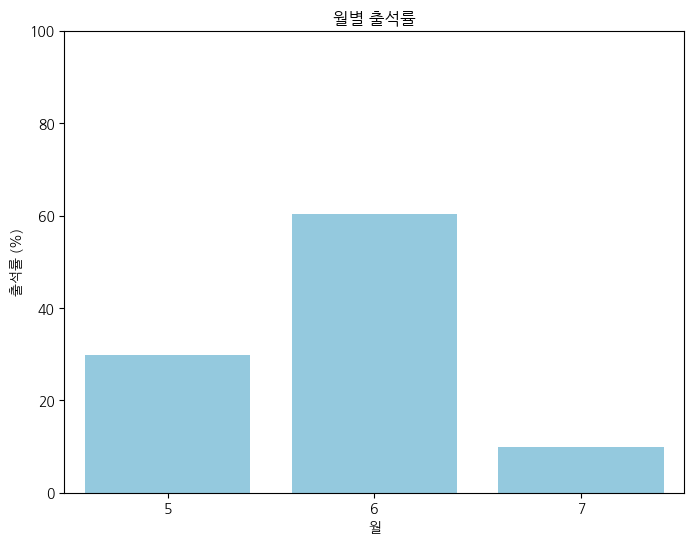

In [12]:
# 월별 누적 출석률 시각화

# 월별 사용자 수 집계
monthly_attendance['전체출석횟수'] = monthly_attendance['출석횟수'].sum()
monthly_attendance['출석률'] = (monthly_attendance['출석횟수'] / monthly_attendance['전체출석횟수']) * 100
display(monthly_attendance)

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석률', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석률 (%)')
plt.title('월별 출석률')
plt.ylim(0, 100)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [13]:
# 주차 계산
attendance_filtered['week'] =attendance_filtered['attendance_date_list'].dt.isocalendar().week
attendance_filtered

,id,attendance_date_list,user_id,attendance_count,month,year,week
0,1,2023-05-27,1446852,13,5,2023,21
0,1,2023-05-28,1446852,13,5,2023,21
0,1,2023-05-29,1446852,13,5,2023,22
0,1,2023-05-30,1446852,13,5,2023,22
0,1,2023-06-03,1446852,13,6,2023,22
...,...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023,31
339378,350176,2023-07-31,1537582,1,7,2023,31
339379,350177,2023-07-31,1345721,1,7,2023,31
339380,350178,2023-07-31,1307547,1,7,2023,31


In [14]:
wau_df = (
    attendance_filtered
    .groupby(['week'])['user_id']
    .nunique()
    .reset_index(name='WAU')
)
wau_df

,week,WAU
0,21,130312
1,22,273432
2,23,148277
3,24,76798
4,25,60000
5,26,32390
6,27,21902
7,28,26215
8,29,22174
9,30,19015


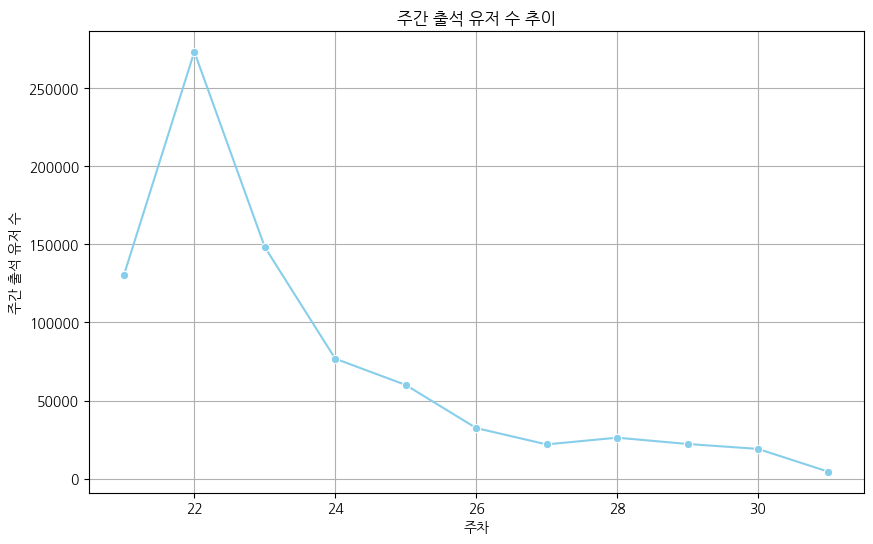

In [15]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=wau_df, x='week', y='WAU', marker='o', color='skyblue')
plt.xlabel('주차')
plt.ylabel('주간 출석 유저 수')
plt.title('주간 출석 유저 수 추이')
plt.grid(True)
plt.show()

   attendance_date_list  daily_active_users
0            2023-05-27               62417
1            2023-05-28               94220
2            2023-05-29              172836
3            2023-05-30              166052
4            2023-05-31              115713
..                  ...                 ...
61           2023-07-27                5799
62           2023-07-28                5972
63           2023-07-29                6047
64           2023-07-30                4723
65           2023-07-31                4405

[66 rows x 2 columns]


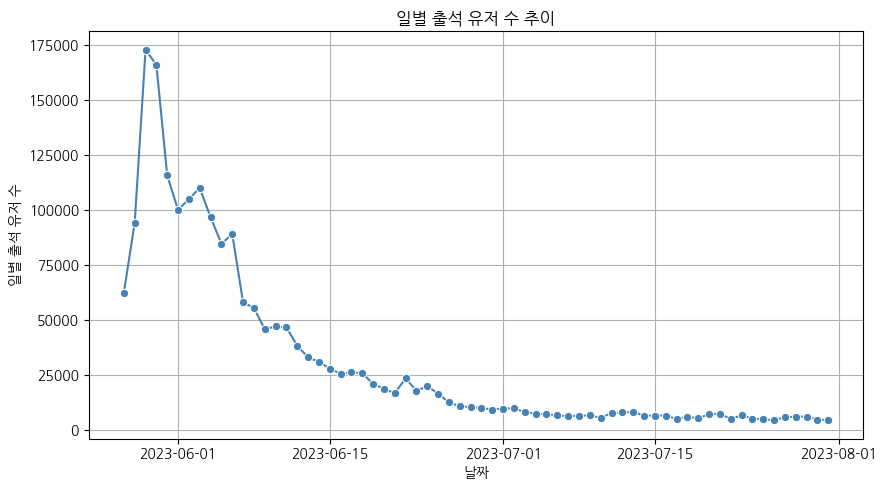

In [16]:
daily_attendance = (
    attendance_filtered
    .groupby('attendance_date_list')['user_id']
    .nunique()
    .reset_index(name='daily_active_users')
)
print(daily_attendance)

# 일별 출석 유저 수
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=daily_attendance,
    x='attendance_date_list',
    y='daily_active_users',
    marker='o',
    color='steelblue'
)
plt.xlabel('날짜')
plt.ylabel('일별 출석 유저 수')
plt.title('일별 출석 유저 수 추이')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. accounts_blockboard(차단 기록) 

In [17]:
blob = bucket.blob('votes/accounts_blockrecord.parquet')
parquet_bytes = blob.download_as_bytes()
blockrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
blockrecord.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [18]:
blockrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [19]:
blockrecord_df = blockrecord.copy()

# 사용 데이터 기간 5,6,7월
blockrecord_df = blockrecord[
    (blockrecord['created_at'].dt.year == 2023) &
    (blockrecord['created_at'].dt.month.isin([5, 6, 7]))
]
blockrecord_df

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19109,24633,친구 사이가 어색해짐,2023-07-31 05:58:03,1575252,1189694
19110,24634,친구 사이가 어색해짐,2023-07-31 07:33:15,1366472,1290241
19111,24635,사칭 계정,2023-07-31 10:30:39,1538473,1147008
19112,24636,친구 사이가 어색해짐,2023-07-31 15:18:11,1120482,1169555


## 3. accounts_failpaymenthistory(상품 구매 실패 기록)

In [20]:
blob = bucket.blob('votes/accounts_failpaymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
failpaymenthistory = pd.read_parquet(io.BytesIO(parquet_bytes))
failpaymenthistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [21]:
failpaymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [22]:
# 사용 데이터 기간 5,6,7월
failpaymenthistory_df = failpaymenthistory.copy()

# 사용 데이터 기간 5,6,7월
failpaymenthistory_df = failpaymenthistory[
    (failpaymenthistory['created_at'].dt.year == 2023) &
    (failpaymenthistory['created_at'].dt.month.isin([5, 6, 7]))
]
failpaymenthistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
154,166,None,I,2023-06-25 11:37:53,897014
155,167,None,I,2023-07-04 13:42:28,1575434
156,168,None,I,2023-07-12 12:14:11,925534
157,169,heart.777,A,2023-07-18 10:17:49,986403


## 4. accounts_friendrequest(친구요청)

In [23]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [24]:
friendrequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147175 entries, 0 to 17147174
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   status           object        
 2   created_at       datetime64[ns]
 3   updated_at       datetime64[ns]
 4   receive_user_id  int64         
 5   send_user_id     int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 784.9+ MB


In [25]:
friendrequest_df = friendrequest.copy()

# 사용 데이터 기간 5,6,7월
friendrequest_df = friendrequest[
    (friendrequest['created_at'].dt.year == 2023) &
    (friendrequest['created_at'].dt.month.isin([5, 6, 7]))
]
friendrequest_df

,id,status,created_at,updated_at,receive_user_id,send_user_id
287213,370203,A,2023-05-01 00:00:02,2023-05-01 04:02:23,855424,862506
287214,370204,A,2023-05-01 00:00:06,2023-05-07 08:40:52,846127,853077
287215,370205,A,2023-05-01 00:00:06,2023-05-01 11:15:28,857441,862516
287216,370206,A,2023-05-01 00:00:06,2023-05-01 01:04:22,861993,862516
287217,370207,A,2023-05-01 00:00:06,2023-05-01 07:45:47,862510,862516
...,...,...,...,...,...,...
17061206,19600792,P,2023-07-31 21:53:23,2023-07-31 21:53:23,1241028,1261414
17061207,19600794,A,2023-07-31 22:37:49,2023-08-01 03:03:38,1300597,1207740
17061208,19600795,P,2023-07-31 22:48:32,2023-07-31 22:48:32,900525,892829
17061209,19600796,A,2023-07-31 23:18:43,2023-08-19 01:49:44,1579552,1233407


In [26]:
# status 상태
friendrequest_df['status'].value_counts()

status
A    12634740
P     3815788
R      323470
Name: count, dtype: int64

In [27]:
# 친구 요청 상태 status가 A(수락)인 유저들의 투표율
send_user_id_a = friendrequest_df[friendrequest_df['status'] == 'A']
send_user_id_a

,id,status,created_at,updated_at,receive_user_id,send_user_id
287213,370203,A,2023-05-01 00:00:02,2023-05-01 04:02:23,855424,862506
287214,370204,A,2023-05-01 00:00:06,2023-05-07 08:40:52,846127,853077
287215,370205,A,2023-05-01 00:00:06,2023-05-01 11:15:28,857441,862516
287216,370206,A,2023-05-01 00:00:06,2023-05-01 01:04:22,861993,862516
287217,370207,A,2023-05-01 00:00:06,2023-05-01 07:45:47,862510,862516
...,...,...,...,...,...,...
17061110,19600693,A,2023-07-31 21:05:08,2023-08-20 12:16:41,917756,1579644
17061196,19600782,A,2023-07-31 21:05:08,2023-08-23 14:32:42,1190085,1579644
17061198,19600784,A,2023-07-31 21:05:08,2023-08-01 01:48:34,1263898,1579644
17061207,19600794,A,2023-07-31 22:37:49,2023-08-01 03:03:38,1300597,1207740


In [28]:
# 친구 요청 수락 많이 받은 유저
send_user_count = send_user_id_a.groupby('send_user_id').size().reset_index(name = 'send_user_count')
send_user_count.sort_values(by = 'send_user_count', ascending = False)

,send_user_id,send_user_count
14843,868174,654
591447,1533716,626
437508,1353849,570
308200,1203441,521
298612,1192441,501
...,...,...
600110,1543423,1
455819,1375748,1
134956,1006172,1
316277,1212745,1


## 5. accounts_group(학급 테이블)

In [29]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [30]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84515 entries, 0 to 84514
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         84515 non-null  int64
 1   grade      84515 non-null  int64
 2   class_num  84515 non-null  int64
 3   school_id  84515 non-null  int64
dtypes: int64(4)
memory usage: 2.6 MB


In [31]:
group.describe()

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [32]:
group['grade'].value_counts()

grade
2     35581
3     29273
1     19659
4         1
20        1
Name: count, dtype: int64

In [33]:
group['class_num'].value_counts()

class_num
1     12125
2     11077
3     10276
4      9506
5      8578
6      7555
7      6390
8      5294
9      3799
10     3067
20     2454
11     1600
12      998
13      506
14      311
18      217
15      216
17      214
19      177
16      152
0         2
41        1
Name: count, dtype: int64

In [34]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [35]:
print(group_df['grade'].value_counts())
print(group_df['class_num'].value_counts())

grade
2    35579
3    29273
1    19658
Name: count, dtype: int64
class_num
1     12125
2     11077
3     10276
4      9506
5      8578
6      7555
7      6389
8      5294
9      3799
10     3066
20     2454
11     1600
12      998
13      506
14      311
18      217
15      216
17      214
19      177
16      152
Name: count, dtype: int64


In [36]:
group_df['school_id'].nunique()

5604

In [37]:
# 학교별 -> 학년별 -> 반 학생 수 -> 각 학교 서비스 가입 전체 학생 수
# 반별 학생 수
group_counts = group_df.groupby(['school_id', 'grade', 'class_num']).size().reset_index(name='user_counts')

# 학교별 전체 학생 수
school_counts = group_df.groupby('school_id').size().reset_index(name='school_total_user_count')

# 병합
group_counts = group_counts.merge(school_counts, on='school_id', how='left')

group_counts

,school_id,grade,class_num,user_counts,school_total_user_count
0,1,1,1,1,26
1,1,1,2,1,26
2,1,1,3,1,26
3,1,1,4,1,26
4,1,1,5,1,26
...,...,...,...,...,...
84500,5965,1,10,1,7
84501,5965,1,19,1,7
84502,5965,2,1,1,7
84503,5965,2,5,1,7


In [38]:
group_counts.sort_values(by = 'school_total_user_count', ascending = False)

,school_id,grade,class_num,user_counts,school_total_user_count
46830,3283,1,12,1,49
46867,3283,3,20,1,49
46844,3283,2,10,1,49
46845,3283,2,11,1,49
46846,3283,2,12,1,49
...,...,...,...,...,...
14980,1371,3,1,1,1
54634,3982,2,1,1,1
77527,5421,2,1,1,1
15029,1376,3,1,1,1


In [39]:
# 각 학교별 총 이용자 수
school_user_counts = group_counts.groupby('school_id')['school_total_user_count'].first().reset_index()
school_user_counts = school_user_counts.sort_values(by = 'school_total_user_count', ascending = False)
school_user_counts

,school_id,school_total_user_count
3108,3283,49
1646,1773,44
1380,1492,44
2076,2212,43
247,271,43
...,...,...
3424,3623,1
3415,3610,1
3414,3609,1
313,342,1


## 6. accounts_nearbyschool(가까운 학교 기록해주는 관계형 테이블)

In [40]:
blob = bucket.blob('votes/accounts_nearbyschool.parquet')
parquet_bytes = blob.download_as_bytes()
nearbyschool = pd.read_parquet(io.BytesIO(parquet_bytes))
nearbyschool.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


## 7. accounts_paymenthistory(구매 기록)

In [41]:
blob = bucket.blob('votes/accounts_paymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
paymetnhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
paymetnhistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [42]:
paymetnhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB


In [43]:
paymetnhistory_df = paymetnhistory.copy()

# 사용 데이터 기간 5,6,7월
paymetnhistory_df = paymetnhistory[
    (paymetnhistory['created_at'].dt.year == 2023) &
    (paymetnhistory['created_at'].dt.month.isin([5, 6, 7]))
]
paymetnhistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
92119,95040,heart.200,I,2023-07-31 19:28:16,1322228
92120,95041,heart.777,I,2023-07-31 19:40:25,1110543
92121,95042,heart.777,I,2023-07-31 20:01:35,1334617
92122,95043,heart.777,A,2023-07-31 20:06:55,1342405


## 8. accounts_user_contacts(유저 컨택)

In [44]:
blob = bucket.blob('votes/accounts_user_contacts.parquet')
parquet_bytes = blob.download_as_bytes()
user_contacts = pd.read_parquet(io.BytesIO(parquet_bytes))
user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


In [45]:
# 전화번호를 가지고 있는 유저 수가 가정 많은 경우 => 114건(아는 친구 많다다)
user_contacts['contacts_count'].max()

114

In [46]:
user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


## 9. accounts_pointhisotry(포인트 기록 테이블)
- delta_point(포인트 양)
- user_question_record_id(투표 기록 id)

In [47]:
blob = bucket.blob('votes/accounts_pointhistory.parquet')
parquet_bytes = blob.download_as_bytes()
pointhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
pointhistory.head()

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


In [48]:
pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [49]:
pointhistory_df = pointhistory.copy()

# 사용 데이터 기간 5,6,7월
pointhistory_df = pointhistory[
    (pointhistory['created_at'].dt.year == 2023) &
    (pointhistory['created_at'].dt.month.isin([5, 6, 7]))
]
pointhistory_df

,id,delta_point,created_at,user_id,user_question_record_id
31727,1523193,5,2023-05-01 03:37:42,857913,1481996.0
31728,1523404,8,2023-05-01 03:38:24,856430,1482200.0
31729,1523478,8,2023-05-01 03:38:38,856430,1482273.0
31730,1523527,7,2023-05-01 03:38:48,856430,1482321.0
31731,1523553,11,2023-05-01 03:38:53,856430,1482347.0
...,...,...,...,...,...
2326983,337419974,300,2023-07-31 17:53:26,849103,NaN
2326984,337420447,230,2023-07-31 18:05:02,865130,NaN
2326985,337420458,-500,2023-07-31 18:05:46,865130,2137872.0
2326986,337420485,-1000,2023-07-31 18:06:18,865130,3110206.0


## 10. accounts_school(학교)

In [50]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [51]:
school['address'].value_counts()

address
경기도 화성시         78
경기도 부천시         60
경상남도 김해시        58
경기도 남양주시        58
대구광역시 달서구       56
                ..
대한민국 강원도 철원군     1
서울 노원구           1
서울 마포구           1
경기 용인시 수지구       1
경북 김천시           1
Name: count, Length: 278, dtype: int64

## 11. accounts_timelinereport(유저 신고 기록)
- user_question_record_id : 투표기록 id
- reported_user_id : 신고 대상 유저 id

In [52]:
blob = bucket.blob('votes/accounts_timelinereport.parquet')
parquet_bytes = blob.download_as_bytes()
timelineReport = pd.read_parquet(io.BytesIO(parquet_bytes))
timelineReport.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


In [53]:
timelineReport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       208 non-null    int64         
 1   reason                   208 non-null    object        
 2   created_at               208 non-null    datetime64[ns]
 3   reported_user_id         208 non-null    int64         
 4   user_id                  208 non-null    int64         
 5   user_question_record_id  208 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.9+ KB


In [54]:
timelineReport_df = timelineReport.copy()

# 사용 데이터 기간 5,6,7월
timelineReport_df = timelineReport[
    (timelineReport['created_at'].dt.year == 2023) &
    (timelineReport['created_at'].dt.month.isin([5, 6, 7]))
]
timelineReport_df

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049
...,...,...,...,...,...,...
203,21857,선정적이거나 폭력적인 내용,2023-05-29 15:42:50,1479859,1402487,131364422
204,22634,허위 사실 언급,2023-05-31 10:33:00,1551005,1161757,135982670
205,22635,허위 사실 언급,2023-05-31 10:33:06,1551005,1161757,134909577
206,23022,선정적이거나 폭력적인 내용,2023-06-01 16:02:33,1479859,1498172,139837310


In [55]:
timelineReport_df['reason'].value_counts().reset_index()

,reason,count
0,허위 사실 언급,80
1,친구를 비하하거나 조롱하는 어투,64
2,선정적이거나 폭력적인 내용,39
3,타인을 사칭함,15
4,광고,10


In [56]:
timelineReport_df['user_question_record_id'].value_counts()

user_question_record_id
78776644     14
18401879      6
5421572       5
5849834       4
96966251      3
             ..
38987321      1
38953737      1
38577730      1
40302296      1
140765885     1
Name: count, Length: 163, dtype: int64

In [57]:
timelineReport_df[timelineReport_df['reason'] == '광고']

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
36,4794,광고,2023-05-10 14:27:44,917587,1084275,18272641
63,7168,광고,2023-05-12 14:54:46,967873,1184397,28992803
64,7169,광고,2023-05-12 14:54:52,967873,1184397,28992803
101,9998,광고,2023-05-14 16:49:58,1207784,1214760,46645583
110,10257,광고,2023-05-15 06:08:04,1250642,1228033,48820574
112,10308,광고,2023-05-15 07:17:06,973584,1228033,48382534
116,10563,광고,2023-05-15 11:38:17,1214817,1275126,50869112
149,13160,광고,2023-05-17 13:16:04,1139317,1290223,65948548
178,14988,광고,2023-05-20 03:40:54,1161706,1206537,72774636
187,17024,광고,2023-05-22 22:12:37,918506,1421864,96310692


## 12. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [58]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [59]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 no

In [60]:
# is_superuser, is_staff 값이 1인 row 제거 및 컬럼 제거

# 1. superuser와 is_staff =1인 행 제거
user =user[(user['is_superuser'] != 1) & (user['is_staff'] != 1)]

# 2. superuser와 is_staff 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff'])
user.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 12:56:35.064406,[],[],N,0,28,0,14,12.0


In [61]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0


In [65]:
# 서비스 이용 전체 유저 수(5,6,7월)
user_df['id'].nunique()

654091

In [66]:
user_df['ban_status'].value_counts()

ban_status
N     646338
W       7213
NB       358
RB       182
Name: count, dtype: int64

In [67]:
# created_at 기준 각 일별 사용자 가입자 수 변화

user_df['created_date'] = user_df['created_at'].dt.date

daily_users = user_df.groupby('created_date')['id'].nunique().reset_index()

daily_users.columns = ['date', 'user_count']

daily_users

/tmp/ipykernel_449343/3719068871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['created_date'] = user_df['created_at'].dt.date


,date,user_count
0,2023-05-01,4640
1,2023-05-02,4071
2,2023-05-03,4231
3,2023-05-04,3473
4,2023-05-05,6334
...,...,...
87,2023-07-27,33
88,2023-07-28,31
89,2023-07-29,25
90,2023-07-30,15


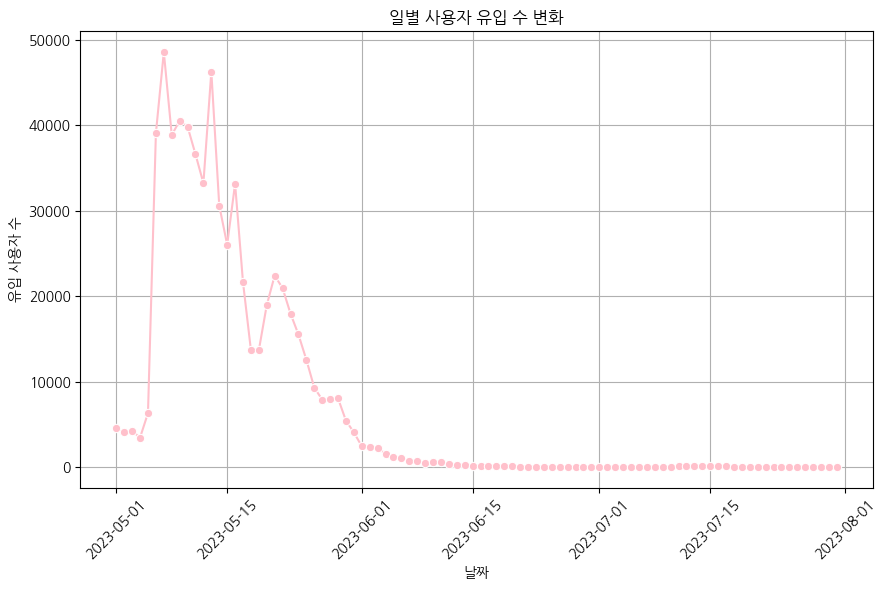

In [68]:
plt.figure(figsize=(9, 6))
sns.lineplot(x='date', y='user_count', data=daily_users, marker='o', color = 'pink')
plt.title('일별 사용자 유입 수 변화')
plt.xlabel('날짜')
plt.ylabel('유입 사용자 수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 13. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

유령회원을 알아보자(기간을 나눠서 보자)

In [69]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [70]:
userquestionrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217558 entries, 0 to 1217557
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1217558 non-null  int64         
 1   status             1217558 non-null  object        
 2   created_at         1217558 non-null  datetime64[ns]
 3   chosen_user_id     1217558 non-null  int64         
 4   question_id        1217558 non-null  int64         
 5   user_id            1217558 non-null  int64         
 6   question_piece_id  1217558 non-null  int64         
 7   has_read           1217558 non-null  int64         
 8   answer_status      1217558 non-null  object        
 9   answer_updated_at  1217558 non-null  datetime64[ns]
 10  report_count       1217558 non-null  int64         
 11  opened_times       1217558 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(2)
memory usage: 111.5+ MB


#### 13-1. 데이터 기한 설정

In [71]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([5, 6, 7]))
]
userquestionrecord_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


In [72]:
userquestionrecord_df[(userquestionrecord_df['has_read'] == 1) & (userquestionrecord_df['answer_status'] != 'N')&(userquestionrecord_df['status']!='B')]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
31250,1492826,C,2023-05-01 04:15:15,855041,219,857609,1866074,1,A,2023-05-07 02:37:03,0,0
31473,1501045,C,2023-05-01 04:41:58,856487,228,849692,1841933,1,A,2023-05-06 08:55:49,0,0
32045,1511111,C,2023-05-01 05:17:08,855041,231,857262,1853099,1,A,2023-05-07 02:36:24,0,0
32544,1522678,C,2023-05-01 05:57:14,856665,232,857926,1950452,1,A,2023-05-07 06:01:02,0,0
32555,1522873,C,2023-05-01 05:57:49,855041,313,855817,1966325,1,A,2023-05-07 02:36:15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1182397,150784898,C,2023-06-07 15:41:57,887991,2356,883374,191553936,1,A,2023-06-07 15:42:58,0,0
1182400,150785481,C,2023-06-07 15:42:37,887991,3822,883374,191553939,1,A,2023-06-07 15:43:09,0,0
1182563,150825226,C,2023-06-07 16:41:50,869580,2285,877117,192477279,1,A,2023-06-07 16:43:00,0,0
1182570,150825637,I,2023-06-07 16:42:40,887714,2357,869580,190234929,1,A,2023-06-07 17:40:52,0,1


In [73]:
userquestionrecord_df[userquestionrecord_df['has_read'] == 1]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30816,1482715,C,2023-05-01 03:40:02,856197,149,858265,1864700,1,N,2023-05-01 03:40:02,0,0
30817,1482743,C,2023-05-01 03:40:07,856197,168,858265,1864701,1,N,2023-05-01 03:40:07,0,0
30819,1482801,C,2023-05-01 03:40:19,859468,151,857913,1821417,1,N,2023-05-01 03:40:19,0,0
30820,1482802,C,2023-05-01 03:40:19,860392,253,858265,1864703,1,N,2023-05-01 03:40:19,0,0
30826,1482871,C,2023-05-01 03:40:36,859587,271,858467,1865279,1,N,2023-05-01 03:40:36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212207,160262831,C,2023-07-31 16:05:26,1465456,2705,866250,187023483,1,N,2023-07-31 16:05:26,0,0
1212208,160262850,C,2023-07-31 16:05:41,846995,2340,866250,187023484,1,N,2023-07-31 16:05:41,0,0
1212210,160262880,C,2023-07-31 16:06:01,863160,1897,866250,187023486,1,N,2023-07-31 16:06:01,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


## 14. accounts_userwithdraw(탈퇴 기록)

In [74]:
blob = bucket.blob('votes/accounts_userwithdraw.parquet')
parquet_bytes = blob.download_as_bytes()
userwithdraw = pd.read_parquet(io.BytesIO(parquet_bytes))
userwithdraw.head()

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


In [75]:
userwithdraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70764 entries, 0 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          70764 non-null  int64         
 1   reason      70764 non-null  object        
 2   created_at  70764 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ MB


In [76]:
userwithdraw_df = userwithdraw.copy()

# 사용 데이터 기간 5,6,7월
userwithdraw_df = userwithdraw[
    (userwithdraw['created_at'].dt.year == 2023) &
    (userwithdraw['created_at'].dt.month.isin([5, 6, 7]))
]
userwithdraw_df

,id,reason,created_at
2414,2487,기타 이유,2023-05-01 00:27:23
2415,2488,재밌는 질문이 없어서,2023-05-01 00:28:24
2416,2489,기타 이유,2023-05-01 00:43:31
2417,2490,기타 이유,2023-05-01 00:44:45
2418,2491,기타 이유,2023-05-01 00:59:27
...,...,...,...
61707,61837,기타 이유,2023-07-31 18:54:09
61708,61838,기타 이유,2023-07-31 19:00:12
61709,61839,기타 이유,2023-07-31 19:04:24
61710,61840,기타 이유,2023-07-31 22:37:52


## 15. event_receipts(포인트 이벤트 참여)

In [77]:
blob = bucket.blob('votes/event_receipts.parquet')
parquet_bytes = blob.download_as_bytes()
receipts = pd.read_parquet(io.BytesIO(parquet_bytes))
receipts.head()

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


In [78]:
receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [79]:
receipts_df = receipts.copy()

# 사용 데이터 기간 5,6,7월
receipts_df = receipts[
    (receipts['created_at'].dt.year == 2023) &
    (receipts['created_at'].dt.month.isin([5, 6, 7]))
]
receipts_df

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500
...,...,...,...,...,...
247,255,2023-07-30 17:40:28,1,1129632,500
248,256,2023-07-30 19:56:36,1,1291851,500
249,257,2023-07-30 21:39:30,1,877152,500
250,258,2023-07-31 12:52:18,1,1299020,500


In [80]:
# 5,6,7월의 데이터만 볼 경우 이벤트는 1번만 존재재
receipts_df['event_id'].value_counts()

event_id
1    252
Name: count, dtype: int64

## 16. events(포인트 이벤트)
- title : 제목
- plus_point : 추가 포인트
- event_type : 이벤트 종류(FCFS : First-come, First-served, 선착순 또는 먼저 온 순서대로 처리)
- is_expired : 만료 여부
- created_at : 만든 시간

In [81]:
blob = bucket.blob('votes/events.parquet')
parquet_bytes = blob.download_as_bytes()
events = pd.read_parquet(io.BytesIO(parquet_bytes))
events.head()

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


In [82]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          3 non-null      int64         
 1   title       3 non-null      object        
 2   plus_point  3 non-null      int64         
 3   event_type  3 non-null      object        
 4   is_expired  3 non-null      int64         
 5   created_at  3 non-null      datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 276.0+ bytes


## 17. polls_question(질문 데이터)

In [83]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [84]:
polls_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             5025 non-null   int64         
 1   question_text  5025 non-null   object        
 2   created_at     5025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 117.9+ KB


In [85]:
# 생성된 질문 수 => 3903개(질문 생성 날짜 : 2023년 3월 31일 ~ 2023년 06월 06일)
m_question = polls_question['question_text'].value_counts().reset_index()
m_question

,question_text,count
0,vote,56
1,인생 2회차인 것 같은 사람은?,3
2,2세가 가장 귀여울 것 같은 사람은?,3
3,눈이 제일 큰 사람은?,3
4,지금 뭐하는지 궁금한 친구,3
...,...,...
3898,장기자랑 1등 할 것 같은 친구는?,1
3899,키가 제일 클 것 같은 사람은?,1
3900,한번쯤 예쁘다고 생각해본 사람은?,1
3901,인스타 부계가 가장 맛깔나는 친구는?,1


In [86]:
m_question[m_question['count'] > 1]

,question_text,count
0,vote,56
1,인생 2회차인 것 같은 사람은?,3
2,2세가 가장 귀여울 것 같은 사람은?,3
3,눈이 제일 큰 사람은?,3
4,지금 뭐하는지 궁금한 친구,3
...,...,...
1058,모든 퍼스널 컬러를 소화할 것 같은 사람,2
1059,가장 셀카를 잘 찍는 사람은?,2
1060,목욕탕 부끄럼없이 같이 갈수 있는 사람,2
1061,가장 꼬시기 어려운 사람은?,2


In [87]:
# 질문 생성 시기

# created_at 컬럼을 datetime 형식으로 변환 후 date만 추출
polls_question['created_at'] = pd.to_datetime(polls_question['created_at']).dt.date

# 날짜별 value_counts
date_counts = polls_question['created_at'].value_counts().sort_index()

date_counts.reset_index()

,created_at,count
0,2023-03-31,73
1,2023-04-01,154
2,2023-05-02,235
3,2023-05-04,1
4,2023-05-11,91
5,2023-05-15,982
6,2023-06-02,1523
7,2023-06-06,1966


## 18. polls_questionpiece(질문 조각)
- question_id : 질문id
- is_voted : 투표 여부
- is_skipped : 스킵 여부
- created_at : 만든 시간

In [88]:
blob = bucket.blob('votes/polls_questionpiece.parquet')
parquet_bytes = blob.download_as_bytes()
questionpiece = pd.read_parquet(io.BytesIO(parquet_bytes))
questionpiece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [89]:
questionpiece.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265476 entries, 0 to 1265475
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1265476 non-null  int64         
 1   is_voted     1265476 non-null  int64         
 2   created_at   1265476 non-null  datetime64[ns]
 3   question_id  1265476 non-null  int64         
 4   is_skipped   1265476 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 48.3 MB


In [90]:
# 사용 데이터 기간 5,6,7월
questionpiece_df = questionpiece.copy()

questionpiece_df = questionpiece_df[
    (questionpiece_df['created_at'].dt.year == 2023) &
    (questionpiece_df['created_at'].dt.month.isin([5,6,7]))
]

questionpiece_df

,id,is_voted,created_at,question_id,is_skipped
33651,1938548,1,2023-05-01 03:40:07,220,0
33652,1938549,1,2023-05-01 03:40:07,151,0
33653,1938550,1,2023-05-01 03:40:07,248,0
33654,1938551,1,2023-05-01 03:40:07,164,0
33655,1938552,1,2023-05-01 03:40:07,153,0
...,...,...,...,...,...
1259116,206277170,0,2023-07-31 16:06:29,3733,0
1259117,206279731,1,2023-07-31 17:10:06,962,0
1259118,206279732,1,2023-07-31 17:10:06,4320,0
1259119,206279733,1,2023-07-31 17:10:06,1057,0


In [91]:
questionpiece_df['question_id'].value_counts()

question_id
169     1857
170     1855
211     1854
186     1843
102     1814
        ... 
4402       1
4858       1
4246       1
4330       1
4320       1
Name: count, Length: 4848, dtype: int64

## 19. polls_questionreport(질문에 대한 신고 기록)

In [92]:
blob = bucket.blob('votes/polls_questionreport.parquet')
parquet_bytes = blob.download_as_bytes()
questionreport = pd.read_parquet(io.BytesIO(parquet_bytes))
questionreport.head()

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


In [93]:
questionreport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51424 entries, 0 to 51423
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           51424 non-null  int64         
 1   reason       51424 non-null  object        
 2   created_at   51424 non-null  datetime64[ns]
 3   question_id  51424 non-null  int64         
 4   user_id      51424 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.0+ MB


In [94]:
# 사용 데이터 기간 5,6,7월
questionreport_df = questionreport.copy()

questionreport_df = questionreport_df[
    (questionreport_df['created_at'].dt.year == 2023) &
    (questionreport_df['created_at'].dt.month.isin([5,6,7]))
]
questionreport_df

,id,reason,created_at,question_id,user_id
1448,1571,불쾌한 내용이 포함되어 있음,2023-05-01 00:05:13,222,856004
1449,1572,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 00:57:29,237,857734
1450,1573,선정적이거나 자극적인 질문,2023-05-01 01:02:36,296,856076
1451,1574,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 01:02:42,296,856076
1452,1575,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 01:12:24,180,858460
...,...,...,...,...,...
50861,55171,그냥 싫어,2023-07-31 08:56:57,1922,1013628
50862,55172,그냥 싫어,2023-07-31 12:11:03,4811,1441146
50863,55173,나랑 맞지 않는 질문인 것 같음,2023-07-31 14:41:13,547,1291088
50864,55174,자꾸 같은 내용의 질문 반복,2023-07-31 14:54:49,3587,933466


In [95]:
print(questionreport_df['reason'].nunique())
questionreport_df['reason'].value_counts().reset_index()

11


,reason,count
0,그냥 싫어,28042
1,나랑 맞지 않는 질문인 것 같음,9472
2,불쾌한 질문 내용,5329
3,자꾸 같은 내용의 질문 반복,3188
4,한 친구가 질문을 반복적으로 보냄,1687
5,어떻게 이런 생각을? 이 질문 최고!,997
6,이 질문은 재미없어요,243
7,기타,235
8,불쾌한 내용이 포함되어 있음,160
9,오타가 있음,37


## 20. polls_questionset(질문세트)

In [96]:
blob = bucket.blob('votes/polls_questionset.parquet')
parquet_bytes = blob.download_as_bytes()
questionset = pd.read_parquet(io.BytesIO(parquet_bytes))
questionset.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


In [97]:
questionset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [98]:
questionset_df = questionset.copy()

# 사용 데이터 기간 5,6,7월
questionset_df = questionset_df[
    (questionset_df['created_at'].dt.year == 2023) &
    (questionset_df['created_at'].dt.month.isin([5, 6, 7]))
]
questionset_df

,id,question_piece_id_list,opening_time,status,created_at,user_id
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, ...",2023-05-01 04:30:07,F,2023-05-01 03:40:07,856430
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, ...",2023-05-01 04:30:20,F,2023-05-01 03:40:20,857913
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, ...",2023-05-01 04:30:39,F,2023-05-01 03:40:39,858265
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, ...",2023-05-01 04:31:44,F,2023-05-01 03:41:44,858467
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, ...",2023-05-01 04:32:10,F,2023-05-01 03:42:10,856197
...,...,...,...,...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 2...",2023-07-31 16:06:01,F,2023-07-31 15:26:01,1113391
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 2...",2023-07-31 16:22:54,F,2023-07-31 15:42:55,852355
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 2...",2023-07-31 16:41:26,C,2023-07-31 16:01:26,875201
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 2...",2023-07-31 16:46:29,O,2023-07-31 16:06:29,866250


In [99]:
questionset_df['user_id'].value_counts()

user_id
952220     370
849103     246
1184703    215
1162477    203
1213990    200
          ... 
1218109      1
1528224      1
887656       1
1477510      1
966621       1
Name: count, Length: 4950, dtype: int64

In [100]:
#  리스트로 변환 ->  정렬 
questionset_df['question_piece_id_list_sorted'] = questionset_df['question_piece_id_list'].apply(lambda x: sorted(x))
questionset_df

,id,question_piece_id_list,opening_time,status,created_at,user_id,question_piece_id_list_sorted
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, ...",2023-05-01 04:30:07,F,2023-05-01 03:40:07,856430,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, ...",2023-05-01 04:30:20,F,2023-05-01 03:40:20,857913,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, ...",2023-05-01 04:30:39,F,2023-05-01 03:40:39,858265,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, ...",2023-05-01 04:31:44,F,2023-05-01 03:41:44,858467,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, ...",2023-05-01 04:32:10,F,2023-05-01 03:42:10,856197,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
...,...,...,...,...,...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 2...",2023-07-31 16:06:01,F,2023-07-31 15:26:01,1113391,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 2...",2023-07-31 16:22:54,F,2023-07-31 15:42:55,852355,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 2...",2023-07-31 16:41:26,C,2023-07-31 16:01:26,875201,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 2...",2023-07-31 16:46:29,O,2023-07-31 16:06:29,866250,"[ , , , , , , , , , ,, ,, ,, ,, ,, ,, ..."


In [101]:
# import numpy as np
# # 모든 question_piece_id_list를 합쳐서 리스트로 변환
# all_question_piece_ids = np.concatenate(questionset_df['question_piece_id_list'].values)

# # 유니크 값만 뽑기
# unique_question_piece_ids = np.unique(all_question_piece_ids)
# unique_count = len(unique_question_piece_ids)
# print(f"유니크한 question_piece_id 개수: {unique_count}")

## 21. polls_usercandidate(질문 조각에 등장하는 유저)

In [102]:
blob = bucket.blob('votes/polls_usercandidate.parquet')
parquet_bytes = blob.download_as_bytes()
usercandidate = pd.read_parquet(io.BytesIO(parquet_bytes))
usercandidate.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


In [103]:
usercandidate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4769609 entries, 0 to 4769608
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         datetime64[ns]
 2   question_piece_id  int64         
 3   user_id            int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 145.6 MB


In [104]:
usercandidate_df = usercandidate.copy()

usercandidate_df = usercandidate_df[
    (usercandidate_df['created_at'].dt.year == 2023) &
    (usercandidate_df['created_at'].dt.month.isin([5,6,7]))
]

usercandidate_df

,id,created_at,question_piece_id,user_id
119628,5929702,2023-05-01 03:37:42,1821408,855041
119629,5929703,2023-05-01 03:37:42,1821408,855817
119630,5929704,2023-05-01 03:37:42,1821408,857337
119631,5929705,2023-05-01 03:37:42,1821408,859468
119632,5930518,2023-05-01 03:38:24,1861799,850774
...,...,...,...,...
4748242,641058346,2023-07-31 16:06:28,187023490,865846
4748243,641078095,2023-07-31 23:43:10,206270691,874304
4748244,641078096,2023-07-31 23:43:10,206270691,875440
4748245,641078097,2023-07-31 23:43:10,206270691,876706


In [105]:
usercandidate_df['question_piece_id'].nunique()

1181449

### 회원가입 유저들 중 투표한 유저 구하기(account_user, userquestionrecord)
- 방안 1 : 투표에 참여한 유저들 데이터로만 분석
    - 투표율 재정의
        - 분모 : 투표 기록이 있는 user_id의 일자별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 투표 기록이 있는 user_id의 일자별 투표 참여 수
- 방안 2 : 10개 학교의 학생 데이터로만 분석
    - 투표율 재정의
        - 분모 : 10개 학교 학생들의 일별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 10개 학교 학생들 중 일별 투표 참여 수

In [106]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


In [107]:
user.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 12:56:35.064406,[],[],N,0,28,0,14,12.0


In [108]:
# 유저 투표 기록 => 4835명(5월~7월), 5074명
userquestionrecord_df.head()
print("투표 기록 존재하는 유니크 유저 수")
print(userquestionrecord_df['user_id'].nunique())

투표 기록 존재하는 유니크 유저 수
4835


In [109]:
# account_user와 userquestionrecord에 공통으로 존재하는 유저들 추출(id = user_id)

# account_user에서 필요한 컬럼만 선택하고, id를 user_id로 변경
user_filtered = user[[
    'id', 'gender', 'is_push_on', 'ban_status', 
    'alarm_count', 'group_id', 'created_at'
]].rename(columns={'id': 'user_id', 'created_at':'user_created_at'})

user_filtered

# 2023년 7월 31일까지 필터링
user_filtered = user_filtered[user_filtered['user_created_at'] <= '2023-07-31']

# user 7월까지 필터링
user_filtered

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311
5,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406
...,...,...,...,...,...,...,...
673156,1579609,F,1,N,1,84053.0,2023-07-30 10:32:02.154332
673157,1579610,F,1,N,1,73422.0,2023-07-30 10:33:35.970330
673158,1579612,F,1,N,1,30892.0,2023-07-30 14:40:25.203007
673159,1579616,M,0,N,0,56099.0,2023-07-30 21:04:52.642422


In [ ]:
# 두 데이터프레임에서 공통 user_id만 추출

# ① userquestionrecord에서 user_id 목록 추출 (중복 제거)
voted_user_ids = userquestionrecord_df['user_id'].unique()

# ② user에서 해당 user_id만 추출
voted_user = user_filtered[user_filtered['user_id'].isin(voted_user_ids)]

# 결과 확인
print(voted_user.head())
print(f"투표 기록이 있는 유저 수: {voted_user['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
1252   839357      M           1          N            1     519.0   
1889   840293      F           1          N            2     838.0   
2024   840473      M           1          N            0     915.0   

                user_created_at  
396  2023-04-19 09:06:00.719792  
633  2023-04-19 15:10:56.560337  
1252 2023-04-20 14:26:20.479856  
1889 2023-04-21 11:45:56.750174  
2024 2023-04-21 13:45:13.007506  
투표 기록이 있는 유저 수: 4835


In [111]:
# 학교 정보 group_id 기준 merge

# group 데이터에서 id → group_id로 이름 변경 (병합을 위해)
group_renamed = group.rename(columns={'id': 'group_id'})

# voted_user와 group_renamed 병합
voted_user = pd.merge(voted_user, group_renamed, on='group_id', how='left')

# 결과 확인
voted_user.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,grade,class_num,school_id
0,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,1,12,271
1,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,2,2,369
2,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,1,15,271
3,840293,F,1,N,2,838.0,2023-04-21 11:45:56.750174,1,10,369
4,840473,M,1,N,0,915.0,2023-04-21 13:45:13.007506,1,13,369


In [112]:
# 투표한 유저들이 있는 존재하는 학교
voted_user['school_id'].value_counts()

school_id
1719    541
369     537
5372    485
4516    478
5520    477
4426    470
1478    467
5491    462
352     461
271     457
Name: count, dtype: int64

In [113]:
# ① school_id 고유값 추출
school_ids = voted_user['school_id'].unique()

# ② school_id를 DataFrame으로 변환
voted_school_id = pd.DataFrame({'school_id': school_ids})

voted_school_id

,school_id
0,271
1,369
2,5491
3,352
4,4516
5,4426
6,1478
7,5520
8,5372
9,1719


In [114]:
# 7월까까지 필터링한 user 데이터에 학교 정보 추가

# group 테이블에서 id → group_id로 이름 변경
group_renamed = group.rename(columns={'id': 'group_id'})

# user_filtered와 group_renamed 병합
user_school_info = pd.merge(user_filtered, group_renamed, on='group_id', how='left')

# 결과 확인
user_school_info.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,grade,class_num,school_id
0,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368,2.0,1.0,1.0
1,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468,1.0,1.0,1.0
2,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790,1.0,1.0,1.0
3,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311,2.0,1.0,1.0
4,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406,2.0,1.0,1.0


In [115]:
#  투표한 학생들이 존재하는 학교에 해당하는 유저들 추출
user_school_info = user_school_info[user_school_info['school_id'].notna()].copy()
# school_id 컬럼이 float이면 int로 맞춰주는 것이 좋습니다
voted_school_id['school_id'] = voted_school_id['school_id'].astype(int)
user_school_info['school_id'] = user_school_info['school_id'].astype(int)

# 필터링: voted_school_id에 있는 school_id만 남기기
user_school_info = user_school_info[user_school_info['school_id'].isin(voted_school_id['school_id'])]

# 결과 확인
print(user_school_info.head())
print(f"투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: {user_school_info.shape[0]}")

# 유저 투표 기록 => 4835명(5월~7월), 5074명

print(f"투표 기록 존재하는 유니크 유저 수 : {userquestionrecord_df['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
395    838023      F           1          N            1     233.0   
632    838466      F           1          N            1     321.0   
755    838642      F           1          N            0     356.0   
1251   839357      M           1          N            1     519.0   
1496   839670      F           0          N            1     603.0   

                user_created_at  grade  class_num  school_id  
395  2023-04-19 09:06:00.719792    1.0       12.0        271  
632  2023-04-19 15:10:56.560337    2.0        2.0        369  
755  2023-04-20 00:11:00.962160    2.0       10.0        271  
1251 2023-04-20 14:26:20.479856    1.0       15.0        271  
1496 2023-04-21 00:25:27.279382    2.0        4.0        271  
투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: 5074
투표 기록 존재하는 유니크 유저 수 : 4835


In [116]:
user_school_info

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,grade,class_num,school_id
395,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,1.0,12.0,271
632,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,2.0,2.0,369
755,838642,F,1,N,0,356.0,2023-04-20 00:11:00.962160,2.0,10.0,271
1251,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,1.0,15.0,271
1496,839670,F,0,N,1,603.0,2023-04-21 00:25:27.279382,2.0,4.0,271
...,...,...,...,...,...,...,...,...,...,...
671243,1577440,M,1,N,0,8323.0,2023-06-29 08:36:52.982230,1.0,5.0,4516
671572,1577823,F,0,N,1,36400.0,2023-07-06 14:14:30.805435,2.0,9.0,5520
671808,1578095,F,1,N,0,1058.0,2023-07-11 13:25:58.942235,2.0,3.0,369
672118,1578443,F,0,N,1,5027.0,2023-07-13 12:22:54.300096,1.0,4.0,5491


## kpi 구하기

#### 1. 일별 누적 회원 가입수 

In [117]:
# 1. 날짜만 추출
user_school_info['user_date'] = user_school_info['user_created_at'].dt.date

# 2. 전체 날짜 범위: 실제 시작 ~ 7월 31일
full_user_date_range = pd.DataFrame({
    'user_date': pd.date_range(
        start=user_school_info['user_date'].min(),
        end=pd.to_datetime('2023-07-31')
    ).date
})

# 3. 일별 회원가입자 수
daily_user = (
    user_school_info.groupby('user_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_user_count'})
)

# 4. 병합 후 가입 없는 날은 0으로
daily_user_complete = pd.merge(full_user_date_range, daily_user, on='user_date', how='left').fillna(0)
daily_user_complete['daily_user_count'] = daily_user_complete['daily_user_count'].astype(int)

# 5. 누적 가입자 수
daily_user_complete['cumulative_user_count'] = daily_user_complete['daily_user_count'].cumsum()

# 6. 5월 1일부터만 필터링
daily_user_filtered = daily_user_complete[
    daily_user_complete['user_date'] >= pd.to_datetime('2023-05-01').date()
]

# 7. 분리된 DataFrame
daily_user = daily_user_filtered[['user_date', 'daily_user_count']].copy()
cumulative_user = daily_user_filtered[['user_date', 'cumulative_user_count']].copy()

# 결과 확인
display(daily_user)
display(cumulative_user)

,user_date,daily_user_count
12,2023-05-01,43
13,2023-05-02,99
14,2023-05-03,389
15,2023-05-04,184
16,2023-05-05,434
...,...,...
99,2023-07-27,0
100,2023-07-28,0
101,2023-07-29,0
102,2023-07-30,0


,user_date,cumulative_user_count
12,2023-05-01,446
13,2023-05-02,545
14,2023-05-03,934
15,2023-05-04,1118
16,2023-05-05,1552
...,...,...
99,2023-07-27,5074
100,2023-07-28,5074
101,2023-07-29,5074
102,2023-07-30,5074


### 2. 일별 투표 유저 수

In [118]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


In [119]:
# 명시적으로 복사
questionrecord_df = userquestionrecord_df.copy()

# 1. 날짜만 추출
questionrecord_df['vote_date'] = questionrecord_df['created_at'].dt.date

# 2. 일별 고유 유저 수 집계
daily_vote = (
    questionrecord_df.groupby('vote_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_vote_count'})
)

# 3. 5월 1일 이후만 필터링
daily_vote = daily_vote[daily_vote['vote_date'] >= pd.to_datetime('2023-05-01').date()]

# 결과 확인
daily_vote


,vote_date,daily_vote_count
0,2023-05-01,325
1,2023-05-02,413
2,2023-05-03,756
3,2023-05-04,820
4,2023-05-05,1248
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


### 3. 누적 회원가입 유저 데이터 + 일별 투표 유저 데이터 merge

In [120]:
# 날짜 컬럼 이름을 통일
daily_vote_renamed = daily_vote.rename(columns={'vote_date': 'date'})
cumulative_user_renamed = cumulative_user.rename(columns={'user_date': 'date'})

# 날짜 기준 병합
ratio_df = pd.merge(daily_vote_renamed, cumulative_user_renamed, on='date', how='outer')

# 날짜 정렬
ratio_df = ratio_df.sort_values(by='date').reset_index(drop=True)

# 결과 확인
ratio_df

,date,daily_vote_count,cumulative_user_count
0,2023-05-01,325,446
1,2023-05-02,413,545
2,2023-05-03,756,934
3,2023-05-04,820,1118
4,2023-05-05,1248,1552
...,...,...,...
87,2023-07-27,14,5074
88,2023-07-28,14,5074
89,2023-07-29,17,5074
90,2023-07-30,11,5074


In [121]:
# 날짜별 투표율 계산
ratio_df['vote_rate'] = (ratio_df['daily_vote_count'] / ratio_df['cumulative_user_count']) * 100

# 소수점 2자리까지 반올림
ratio_df['vote_rate'] = ratio_df['vote_rate'].round(2)

# 결과 확인
ratio_df[['date', 'daily_vote_count', 'cumulative_user_count', 'vote_rate']]

,date,daily_vote_count,cumulative_user_count,vote_rate
0,2023-05-01,325,446,72.87
1,2023-05-02,413,545,75.78
2,2023-05-03,756,934,80.94
3,2023-05-04,820,1118,73.35
4,2023-05-05,1248,1552,80.41
...,...,...,...,...
87,2023-07-27,14,5074,0.28
88,2023-07-28,14,5074,0.28
89,2023-07-29,17,5074,0.34
90,2023-07-30,11,5074,0.22


# 하위지표 선정 및 분석 수행